# Temperature Observation to Avoid Loggerheads

In [1]:
import numpy as np
import xarray as xr
from dask.distributed import Client


In [2]:
# opendap
# ds_mask = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/cookbook/data/nmme/hci_total_mask.nc')
# local
ds_mask = xr.open_dataset('/Datasets.private/marinehw/nmme_marine_index_mask/hci_total_mask.nc')

In [3]:
link = "http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.sst_regridded/dods"
ds_nmme = xr.open_dataset(link, chunks={'M':1,'L':1,'S':1},decode_times=False)

In [4]:
ds_nmme = ds_nmme.isel(S=slice(-2,None),M=slice(0,5)).load()

In [5]:
ds_nmme

<xarray.Dataset> Size: 31MB
Dimensions:        (L: 12, S: 2, M: 5, X: 360, Y: 181)
Coordinates:
  * L              (L) float32 48B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
  * S              (S) float32 8B 772.0 773.0
  * M              (M) float32 20B 1.0 2.0 3.0 4.0 5.0
  * X              (X) float32 1kB 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * Y              (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
Data variables:
    sst_regridded  (S, L, M, Y, X) float32 31MB nan nan nan nan ... nan nan nan
Attributes:
    Conventions:  IRIDL

In [6]:
import cftime
# all available initial time in the link
ds_nmme['S'] = cftime.num2date(
    ds_nmme.S.values,
    ds_nmme.S.units,
    calendar='360_day'
)

In [7]:
ds_nmme['S'] 

<xarray.DataArray 'S' (S: 2)> Size: 16B
array([cftime.Datetime360Day(2024, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2024, 6, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * S        (S) object 16B 2024-05-01 00:00:00 2024-06-01 00:00:00

In [8]:
# opendap
# ds_threshold = xr.open_dataset('http://psl.noaa.gov/thredds/dodsC/Projects/CEFI/cookbook/data/nmme/GFDL-SPEAR-regridded_climo_threshold_hci.nc')
# local 
ds_threshold = xr.open_dataset('/Datasets.private/marinehw/nmme_sst_stat/GFDL-SPEAR-regridded_climo_threshold_total.nc')

In [9]:
ds_threshold['month'] = ds_threshold['month'].data.astype('int')

In [10]:
ds_threshold

<xarray.Dataset> Size: 1kB
Dimensions:          (month: 12, L: 12)
Coordinates:
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * L                (L) float32 48B 1.5 2.5 3.5 4.5 5.5 ... 9.5 10.5 11.5 12.5
Data variables:
    total_threshold  (month, L) float64 1kB ...

In [11]:
# called compute because da_sst is used twice in the following operation
da_sst = (ds_mask['TOTAL']*ds_nmme['sst_regridded']).compute()


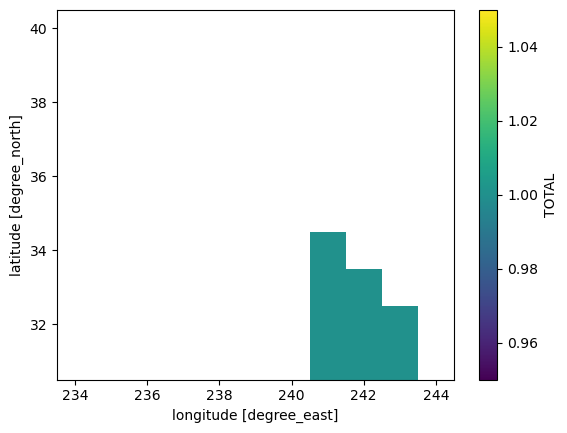

In [12]:
ds_mask['TOTAL'].plot()

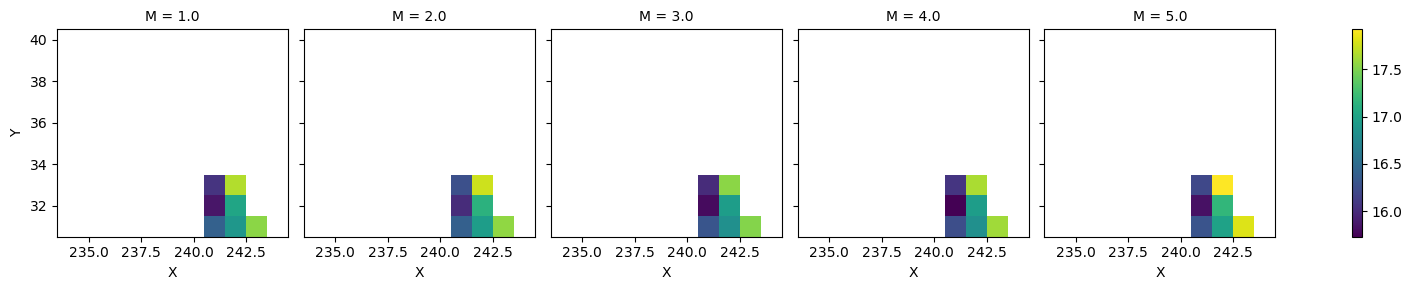

In [13]:
da_sst.isel(L=0,S=-2).plot(col='M')

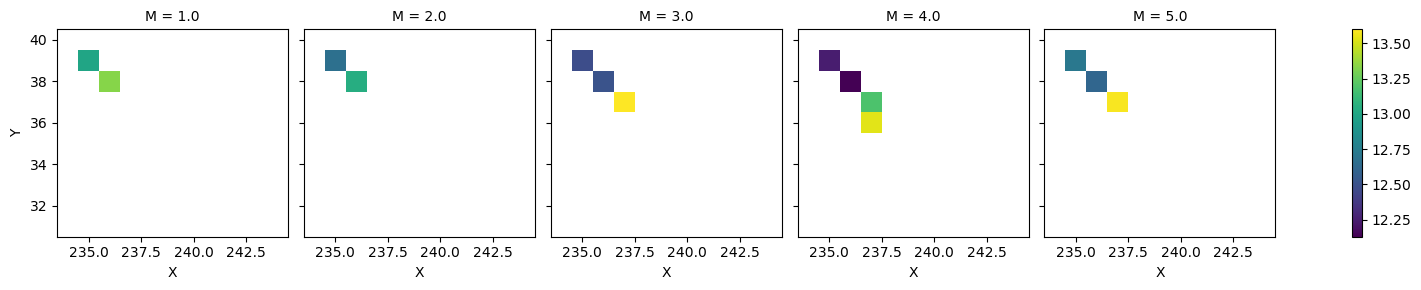

In [ ]:
da_hci = da_sst.where(da_sst.groupby('S.month')<=ds_threshold['hci_threshold'])
da_hci.isel(L=0,S=-2).plot(col='M')

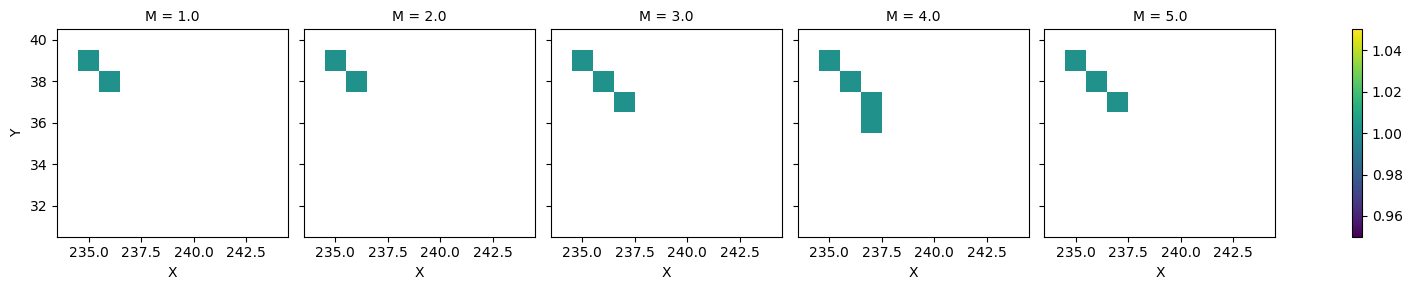

In [ ]:
da_hci = da_hci.where(da_hci.isnull(),other=1)
da_hci.isel(L=0,S=-2).plot(col='M')

In [ ]:
da_hci = da_hci.sum(dim=['X','Y'],skipna=True)

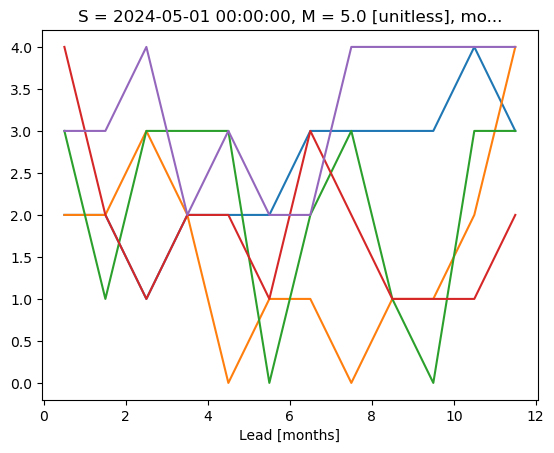

In [ ]:
for m in da_hci.M:
    da_hci.isel(S=-2).sel(M=m).plot()

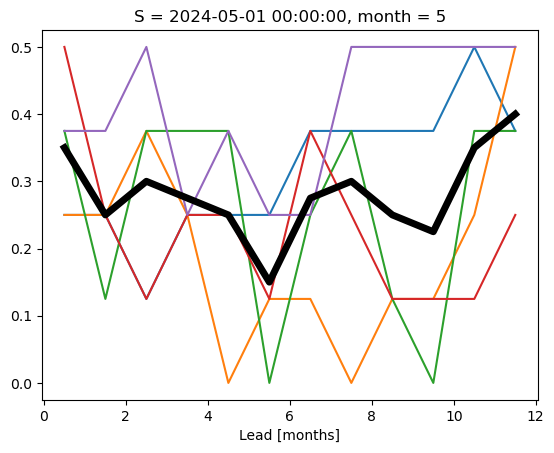

In [ ]:
da_total_grids = ds_mask['HCI_150km'].sum(dim=['X','Y'],skipna=True)
da_hci = da_hci/da_total_grids # percentage of identified grid to total grid
for m in da_hci.M:
    da_hci.isel(S=-2).sel(M=m).plot()

da_hci.mean(dim='M').isel(S=-2).plot(color='k',linewidth=5)

In [1]:
# %%
"""
# NMME Temperature Observations to Avoid Loggerheads (TOTAL)
 
The script calculate the TOTAL value from the start of the nmme 1991 based on 
Brodie et al., [2023]

Using NMME model hindcast and forecast obtained from 
http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/
with variable SST

"""


# %%
# start a local cluster
import json
import subprocess
from datetime import date
import warnings
import numpy as np
import xarray as xr
from dask.distributed import Client
from nmme_download import iri_nmme_models
from nmme_hci_climo_threshold import read_marine_index_mask
from nmme_monthly_mhw import read_nmme_onlist
from nmme_hci_monthly import output_format





warnings.filterwarnings("ignore")

### open local cluster
client = Client(processes=False)
print(client)
print(client.cluster.dashboard_link)

###### Setting ######
# specify date
today = date.today()
# setup the new output file name (same as date of download)
dateform = today.strftime("%y_%m_%d")

# directory where new simulation (inputs) and mhw forecast (outputs) is located
BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'

# directory where sst threshold/climatology/trend (inputs) is located
PREDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

# directory where nmme mhw probability is located
OUTDIR = '/Datasets.private/marinehw/nmme_mhw_prob/'

# directory where the marine index mask is located
MASKDIR = '/Datasets.private/marinehw/nmme_marine_index_mask/'

# output filename date, MHW prediction generated date
date = dateform

# used model list
with open('model_use_list.json','r',encoding='utf-8') as f:
    json_dict = json.load(f)
model_use_list = json_dict['model_use_list']

dict_model = iri_nmme_models()
avai_model_list = list(dict_model.keys())

 

<Client: 'inproc://10.173.16.4/1593331/1' processes=1 threads=96, memory=0.98 TiB>
http://10.173.16.4:8787/status


In [2]:
################################## Main program start #####################################

dict_da = read_nmme_onlist(model_use_list,avai_model_list,BASEDIR,PREDIR,start_year=1991,lazy=False,chunks = {'M':-1,'L':-1,'S':1})

ds_mask = read_marine_index_mask(MASKDIR)




------------
CanCM4i-IC3
------------
reading data
------------
GEM5-NEMO
------------
reading data
------------
GFDL-SPEAR-regridded
------------
reading data
variable name convert from sst_regridded to sst
------------
NASA-GEOSS2S
------------
reading data
------------
COLA-RSMAS-CCSM4
------------
reading data
------------
COLA-RSMAS-CESM1
------------
reading data
------------
NCEP-CFSv2
------------
reading data


In [3]:
da_total_identified_list = []
da_total_all_list = []
for nmodel,model in enumerate(model_use_list):
    if model in avai_model_list:
        threshold_file = f'{PREDIR}{model}_climo_threshold_total.nc'

        print('------------')
        print(model,' TOTAL detection...')
        print('------------')

        # # read threshold (1991-2020)
        # da_threshold = xr.open_dataset(
        #     threshold_file,
        #     chunks={'S':1,'L':1}
        # )['total_threshold']

        da_ssta = ds_mask['TOTAL']*(
            dict_da['da_model_list'][nmodel].groupby('S.month')
            -dict_da['da_climo_list'][nmodel]
        )


        # # calculate area weight
        # weights = np.cos(np.deg2rad(da_ssta.Y))
        # weights.name = "weights"
        # # calculate area weighted mean
        # da_ssta_areamean = da_ssta.weighted(weights).mean(dim=["X","Y"])

        # calculate the 6-month rolling mean of the previous six month
        da_total = da_ssta
        # da_total = da_ssta_areamean.rolling(L=6, center=False).mean()

        # the rolling mean of six month is put in the last month of the six
        #  shift 1 is needed to let the rolling mean represent the monthly
        #  value the is 1 month after the six month window
        # da_total['L'] = da_total['L'].data+1.
        da_total = da_total.compute()

        da_total_all_list.append(da_total)
        # print('calculating TOTAL')
        # da_total_identified = da_total.where(da_total.groupby('S.month')>=da_threshold)
        # da_total_identified = (
        #     da_total_identified
        #     .where(da_total_identified.isnull(),other=1)
        #     .sum(dim=['M'],skipna=True)
        # ).compute()
        # da_total_all = (
        #     da_total
        #     .where(da_total.isnull(),other=1)
        #     .sum(dim=['M'],skipna=True)
        # ).compute()
        # da_total_identified_list.append(da_total_identified)
        # da_total_all_list.append(da_total_all)

        # del da_total

# total identified events higher than threshold (all ensemble and models)
da_total_concat = xr.concat(da_total_all_list,dim='model',join='outer')

------------
CanCM4i-IC3  TOTAL detection...
------------
------------
GEM5-NEMO  TOTAL detection...
------------
------------
GFDL-SPEAR-regridded  TOTAL detection...
------------
------------
NASA-GEOSS2S  TOTAL detection...
------------
------------
COLA-RSMAS-CCSM4  TOTAL detection...
------------
------------
COLA-RSMAS-CESM1  TOTAL detection...
------------
------------
NCEP-CFSv2  TOTAL detection...
------------


In [4]:
da_total_concat.to_netcdf('/Datasets.private/marinehw/nmme_sst_stat/total_mid_product_ssta.nc')

In [133]:
da_total_concat.isel(model=0,L=0,M=0,X=8,Y=0)

<xarray.DataArray (S: 402)> Size: 2kB
array([ 0.02268696,  0.03265762, -0.21194458, -0.69763565, -0.814209  ,
       -1.7409801 , -1.085165  , -0.69734   , -1.3081741 , -0.7155361 ,
       -0.5520878 , -0.450922  , -0.05076885, -0.10049057,  0.7035217 ,
        0.7434654 ,  1.0886841 ,  0.9205494 ,  0.13968849,  0.93196297,
        0.40685272,  0.69697   ,  0.8939266 ,  0.53302574,  0.39524555,
        0.48672867,  0.37554932,  0.37749863,  0.15811157,  0.65034676,
        0.9482517 ,  0.18858528, -0.14340973, -0.34557152,  0.2520504 ,
        0.255682  ,  0.2073183 ,  0.2166481 ,  0.6942444 ,  0.42113876,
        0.1539917 , -0.53993034,  0.00290871, -0.42173576, -0.343544  ,
       -0.24440575, -0.6794987 , -0.98781776, -0.0595274 ,  0.08673477,
        0.7732544 ,  0.59682846, -0.59924316, -0.18284416, -0.35725975,
        0.0860157 , -0.26850128, -0.24059105, -0.28222084,  0.38706017,
        0.08799458,  0.19418716,  0.30960083,  0.28277206,  0.67248535,
        0.62672615, -0.04781151,  0.1212635 ,  0.06639862,  0.510355  ,
       -1.027216  , -0.68691444, -0.1336546 , -0.04696274, -0.4803772 ,
       -0.1748085 , -0.09228516,  0.42534065,  0.10553932,  0.84596443,
        0.6861496 ,  1.2099705 ,  1.4203243 ,  1.2811337 ,  1.2116823 ,
        1.2634315 ,  0.8284607 ,  0.03527451,  0.07571411, -0.2521801 ,
       -0.09200096,  0.29149055,  0.5531235 , -0.52428246, -0.51436806,
       -0.7622013 , -0.93913555, -0.95376205, -1.0430298 , -0.88772964,
...
        0.19935799,  0.77118874,  0.32243538,  0.04982758, -0.23451805,
        0.75696373, -0.16539955,  0.16999531,  0.22275162,  0.4116211 ,
        0.3696251 ,  0.8988342 ,  0.37486458, -0.1201992 ,  1.3317432 ,
        0.8710556 ,  0.02231789,  0.37213707,  0.76099205,  0.72837543,
        1.1293678 ,  0.47155762,  0.722805  ,  0.2026062 ,  0.37809944,
        0.5287876 ,  1.0200367 ,  0.7755356 ,  0.7105198 ,  0.9126339 ,
        1.1456966 ,  1.0734682 ,  0.85113907,  0.6133423 ,  0.8774376 ,
        0.710083  ,  1.0864735 ,  0.59305763, -0.01109123, -0.01917267,
        0.18659401,  0.13934898,  0.09403038, -0.01475811,  0.10617447,
       -0.04107666, -0.02536392,  0.4236145 ,  0.9803028 ,  0.09079933,
       -0.0072155 ,  0.8851242 ,  1.3622227 ,  1.7598019 ,  0.4642086 ,
        0.13853168, -0.6494713 , -0.68289185, -1.0267677 , -0.48287964,
       -0.7853527 , -0.24480247, -0.12833977,  0.10033417,  0.27796364,
       -0.06127357,  0.4513607 ,  0.04881001, -0.00942612, -0.17510986,
       -0.03332901,  0.12197876, -0.66184807, -0.05202293, -0.14326286,
        1.8178024 ,  0.74137306,  0.20578575,  0.09445763,  0.21290302,
       -0.1729393 , -1.0379028 , -0.8724098 , -1.1827698 , -0.58662224,
       -0.597311  , -0.54948235,  0.46465302,  0.21164894,  0.43753624,
        0.47919273,  0.9674196 ,  0.6929054 ,  0.7949524 ,  0.75756454,
       -0.1673584 , -0.10249138], dtype=float32)
Coordinates:
    X        float32 4B 242.0
    Y        float32 4B 31.0
    L        float32 4B 0.5
  * S        (S) object 3kB 1991-01-01 00:00:00 ... 2024-06-01 00:00:00
    M        float32 4B 1.0
    month    (S) int64 3kB 1 2 3 4 5 6 7 8 9 10 11 ... 8 9 10 11 12 1 2 3 4 5 6

In [134]:
da_total_concat_sub = da_total_concat.isel(X=8,Y=0)
da_total_concat_mmm = da_total_concat_sub.mean(dim='M').mean(dim='model')

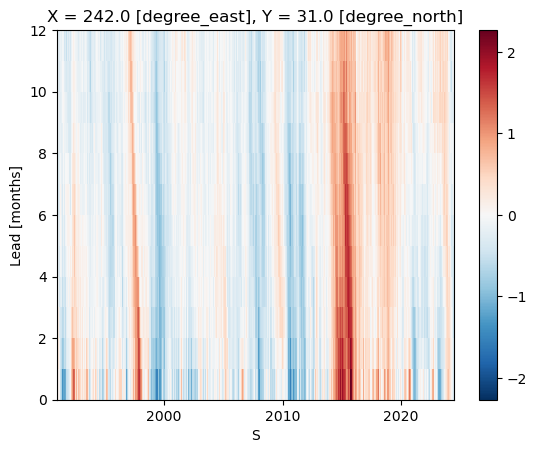

In [140]:
da_total_concat_mmm.plot()

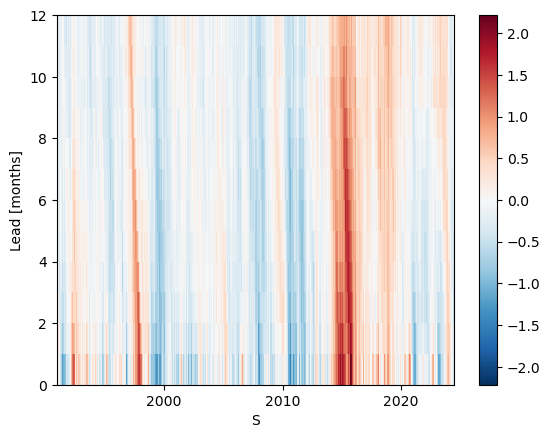

In [141]:
da_total_concat_sub = da_total_concat
da_total_concat_mmm = da_total_concat_sub.mean(dim=['X','Y']).mean(dim='M').mean(dim='model')
da_total_concat_mmm.plot()

In [ ]:
da_total_concat_mmm

Text(0.5, 1.0, 'Time axis is the initial time')

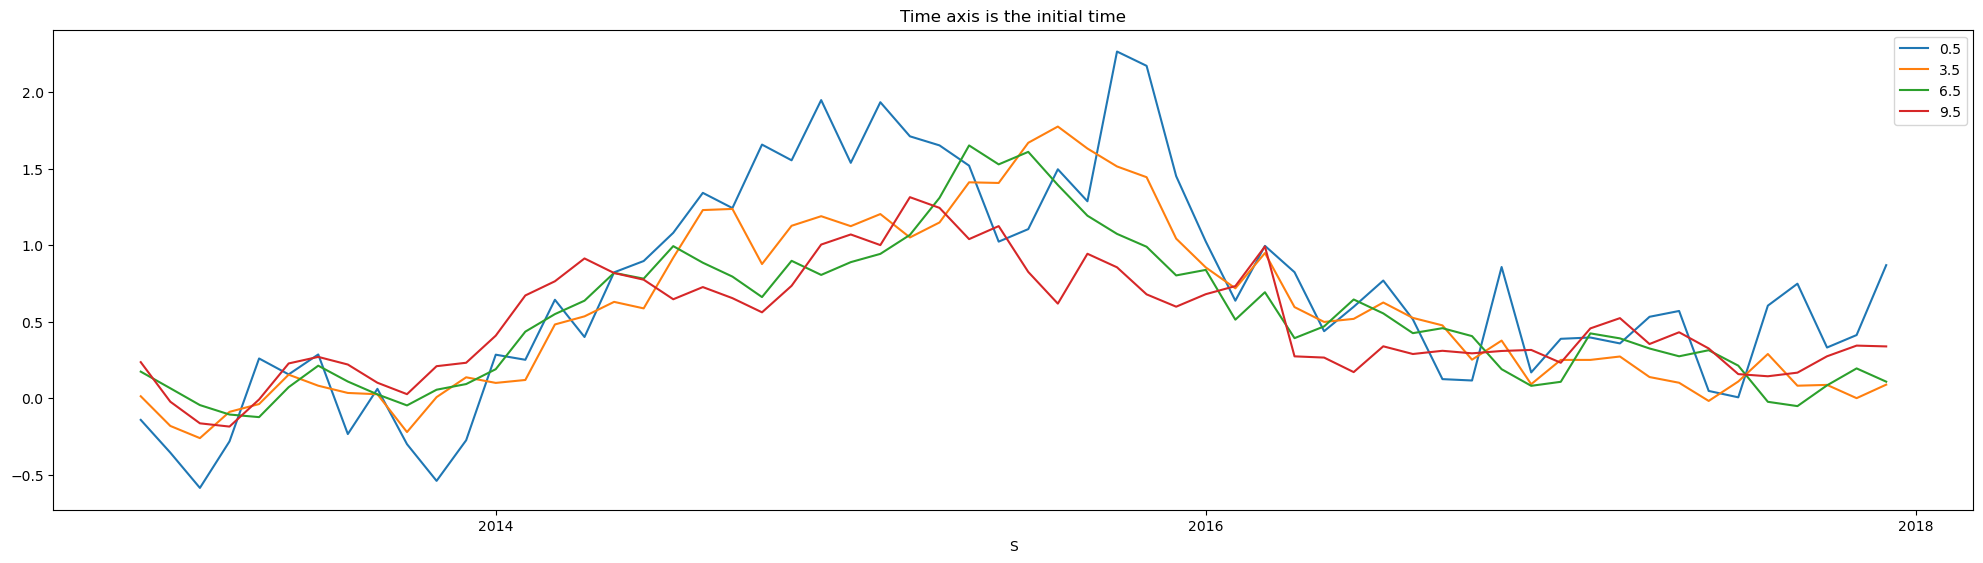

In [135]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for l in da_total_concat_mmm.L.data[::3]:
    da_total_concat_mmm.sel(S=slice('2013-01','2017-12')).sel(L=l).plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the initial time')

Text(0.5, 1.0, 'Time axis is the initial time')

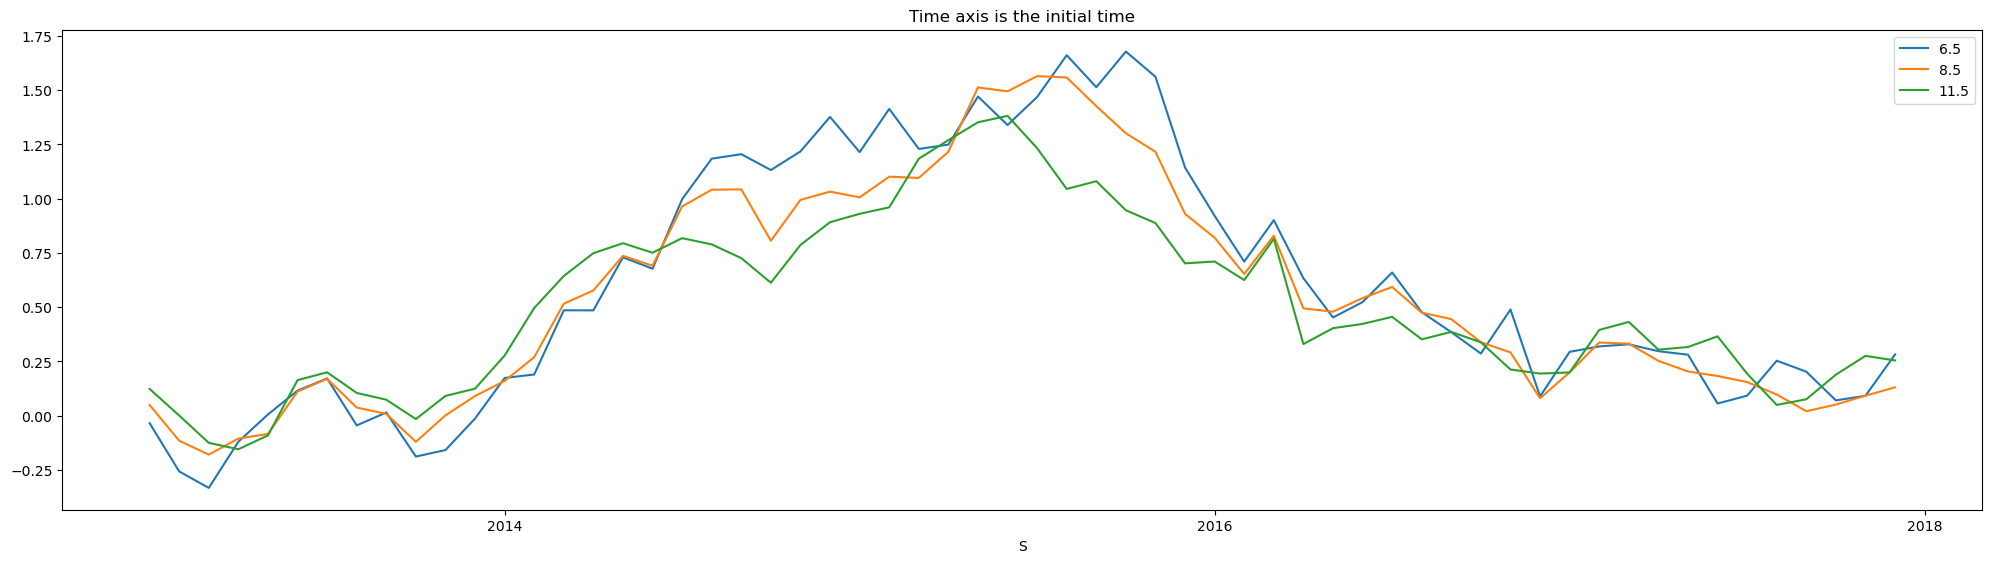

In [136]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for l in [5.5,7.5,10.5]:
    da_total_concat_mmm.rolling(L=6, center=False).mean().sel(S=slice('2013-01','2017-12')).sel(L=l).plot(label=l+1,ax=ax1)
plt.legend()
plt.title('Time axis is the initial time')

Text(0.5, 1.0, 'Time axis is the initial time')

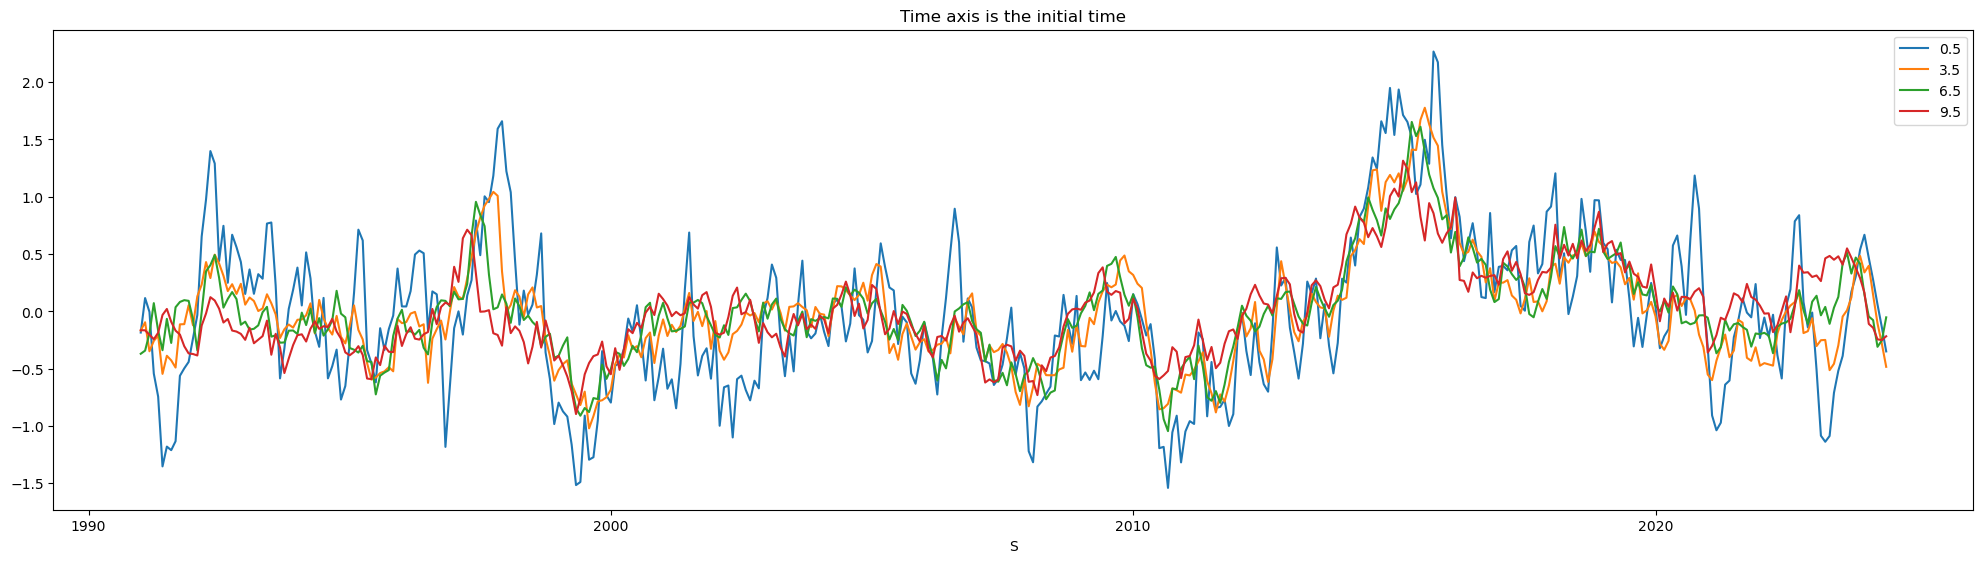

In [137]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for l in da_total_concat_mmm.L.data[::3]:
    da_total_concat_mmm.sel(L=l).plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the initial time')

Text(0.5, 1.0, 'Time axis is the initial time')

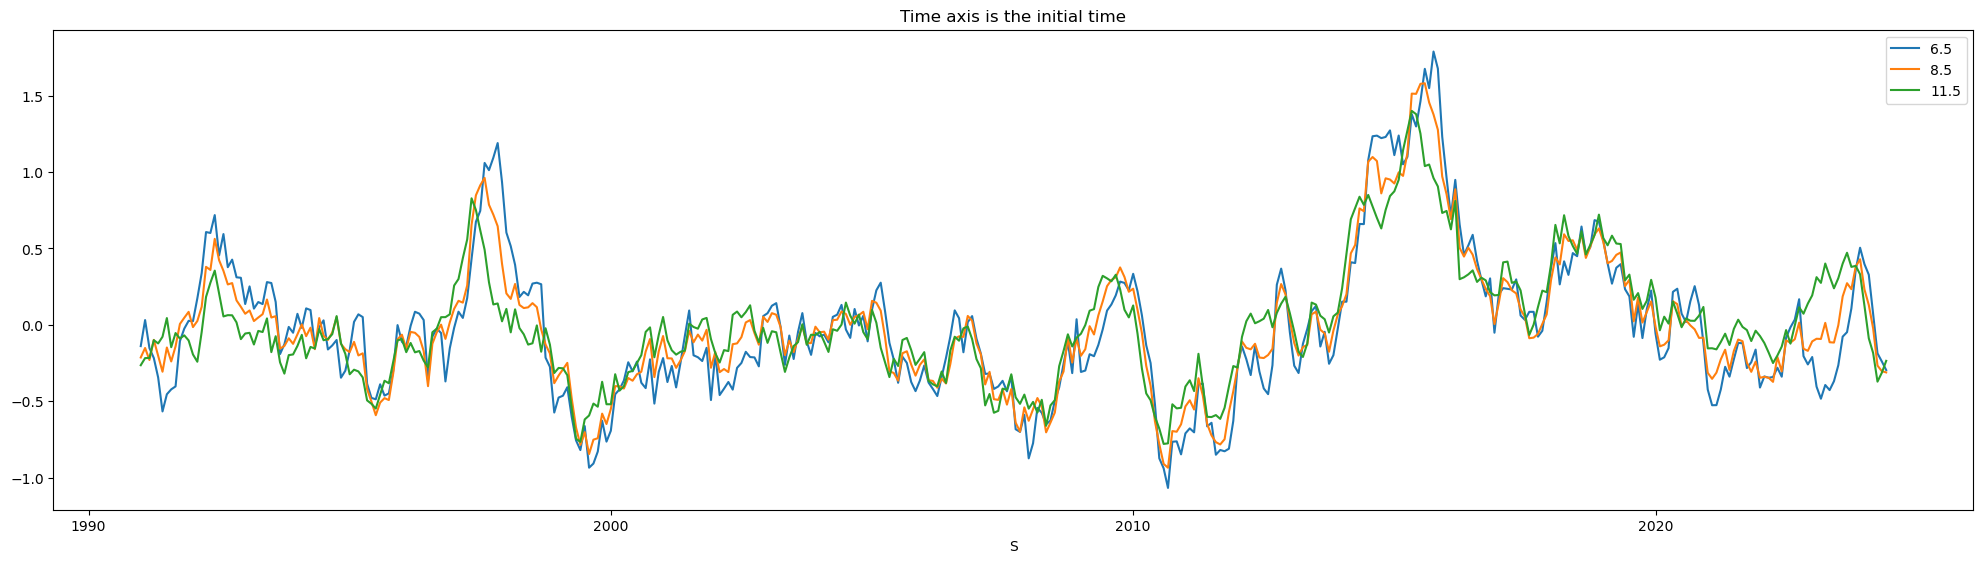

In [128]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for l in [5.5,7.5,10.5]:
    da_total_concat_mmm.rolling(L=6, center=False).mean().sel(L=l).plot(label=l+1,ax=ax1)
plt.legend()
plt.title('Time axis is the initial time')

Text(0.5, 1.0, 'Time axis is the verification time')

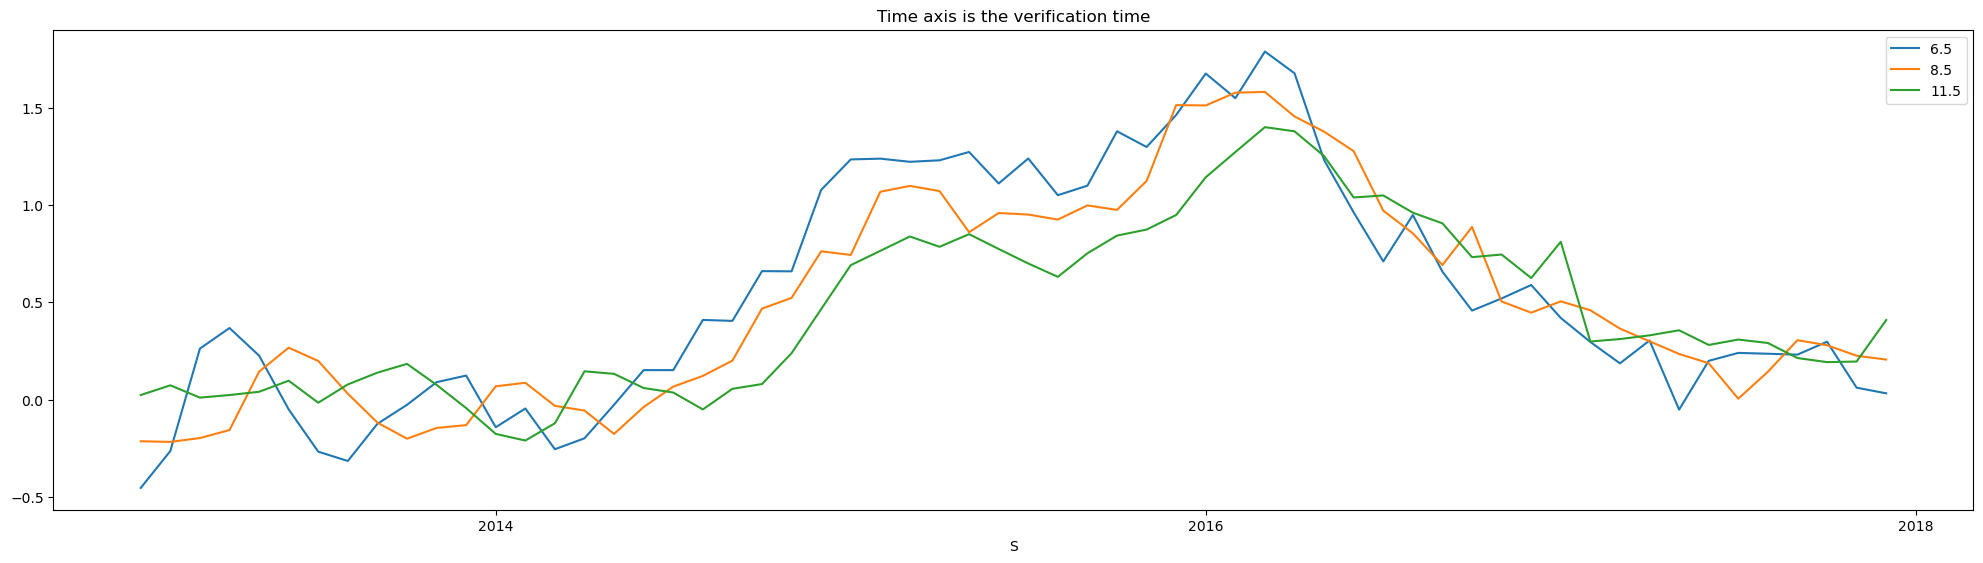

In [129]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
time = da_total_concat_mmm.S.data.copy()
for l in [5.5,7.5,10.5]:
    end = -1*int(np.floor(l))
    time_plot = time[int(np.floor(l)):]
    da_crop = da_total_concat_mmm.rolling(L=6, center=False).mean().sel(L=l).isel(S=slice(0,end))
    da_crop['S'] = time_plot
    da_crop.sel(S=slice('2013-01','2017-12')).plot(label=l+1,ax=ax1)
plt.legend()
plt.title('Time axis is the verification time')

Text(0.5, 1.0, 'Time axis is the verification time')

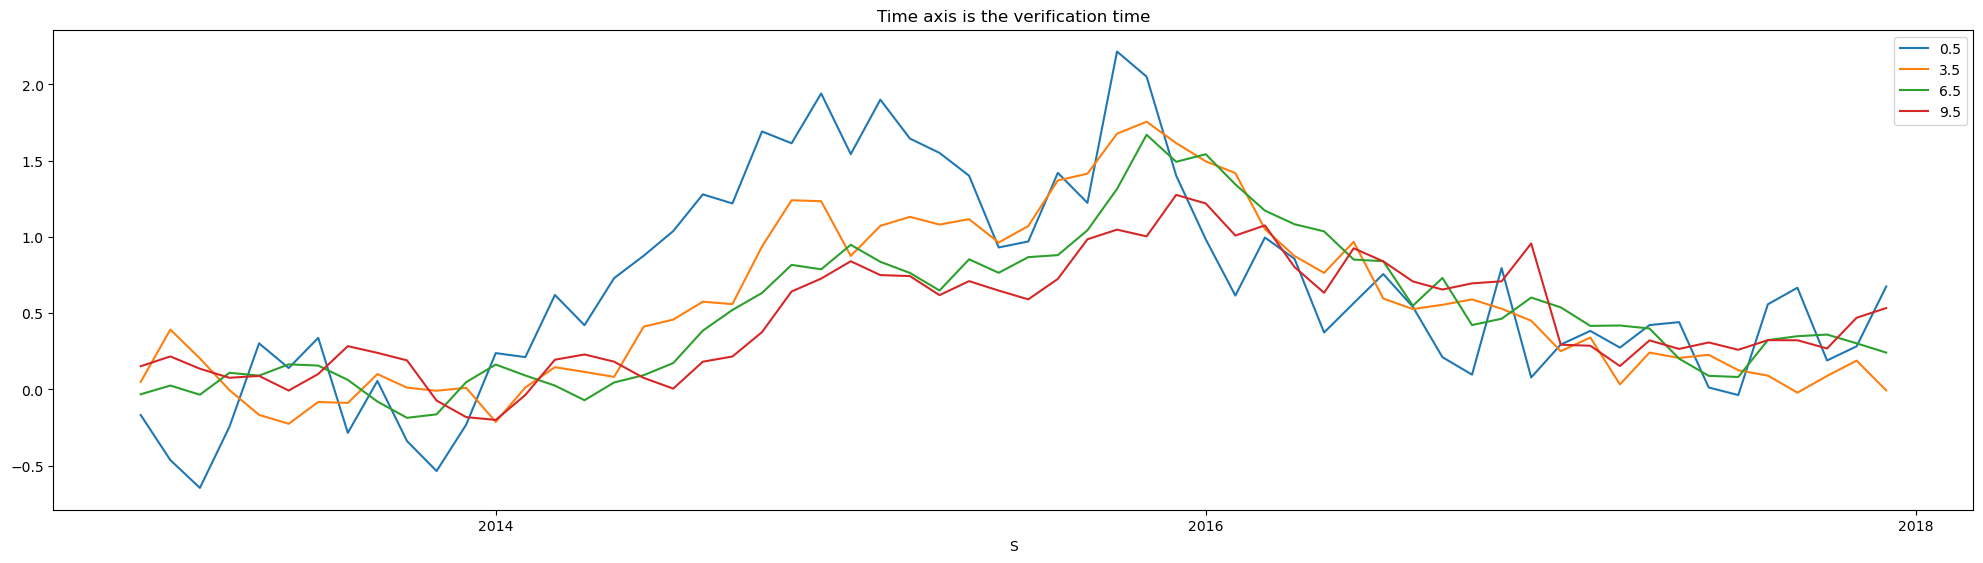

In [102]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
time = da_total_concat_mmm.S.data.copy()
for nl,l in enumerate(da_total_concat_mmm.L.data[::3]):
    if nl == 0:
        end = None
    else:
        end = -1*int(np.floor(l))
    time_plot = time[int(np.floor(l)):]
    da_crop = da_total_concat_mmm.sel(L=l).isel(S=slice(0,end))
    da_crop['S'] = time_plot
    da_crop.sel(S=slice('2013-01','2017-12')).plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the verification time')

Text(0.5, 1.0, 'Time axis is the verification time')

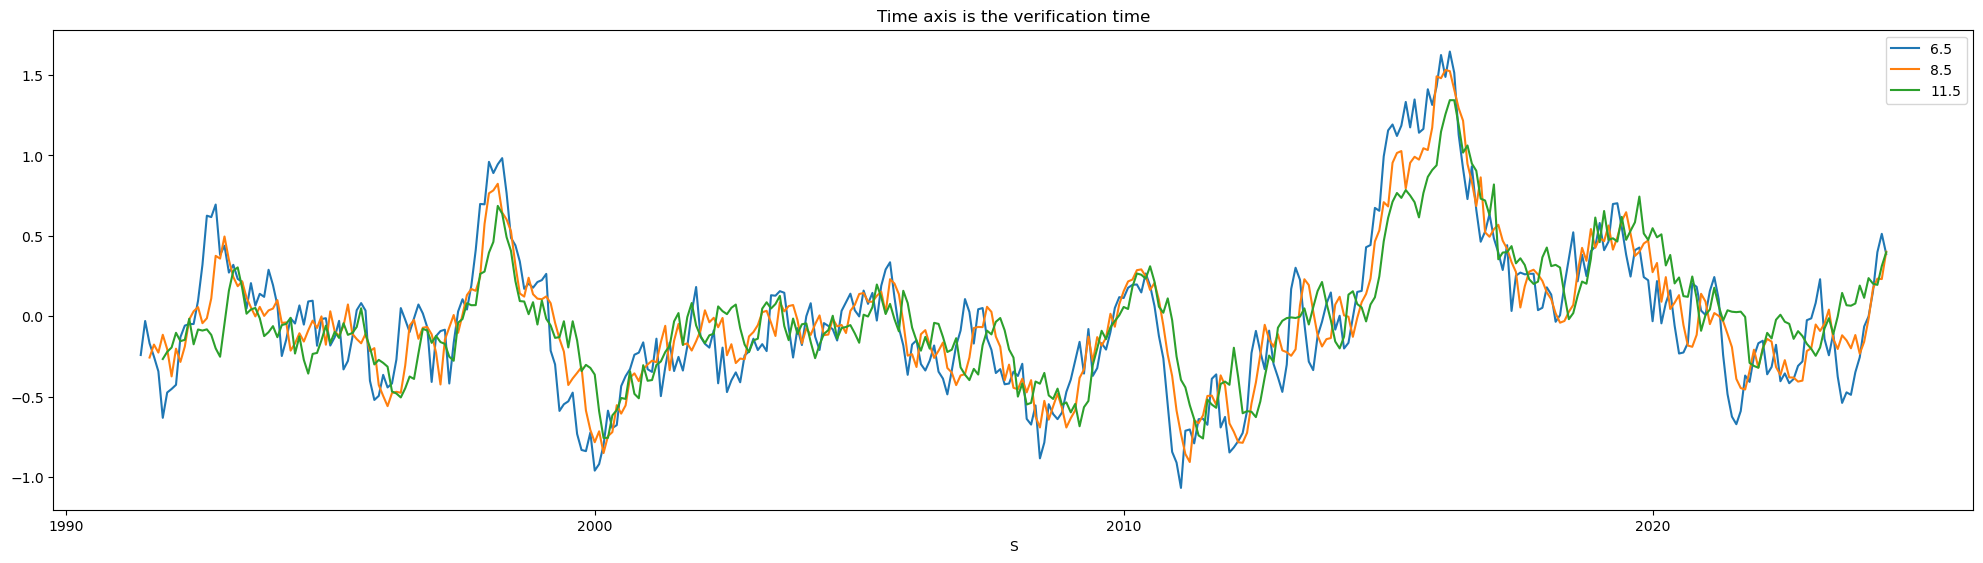

In [103]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
time = da_total_concat_mmm.S.data.copy()
for l in [5.5,7.5,10.5]:
    end = -1*int(np.floor(l))
    time_plot = time[int(np.floor(l)):]
    da_crop = da_total_concat_mmm.rolling(L=6, center=False).mean().sel(L=l).isel(S=slice(0,end))
    da_crop['S'] = time_plot
    da_crop.plot(label=l+1,ax=ax1)
plt.legend()
plt.title('Time axis is the verification time')

Text(0.5, 1.0, 'Time axis is the verification time')

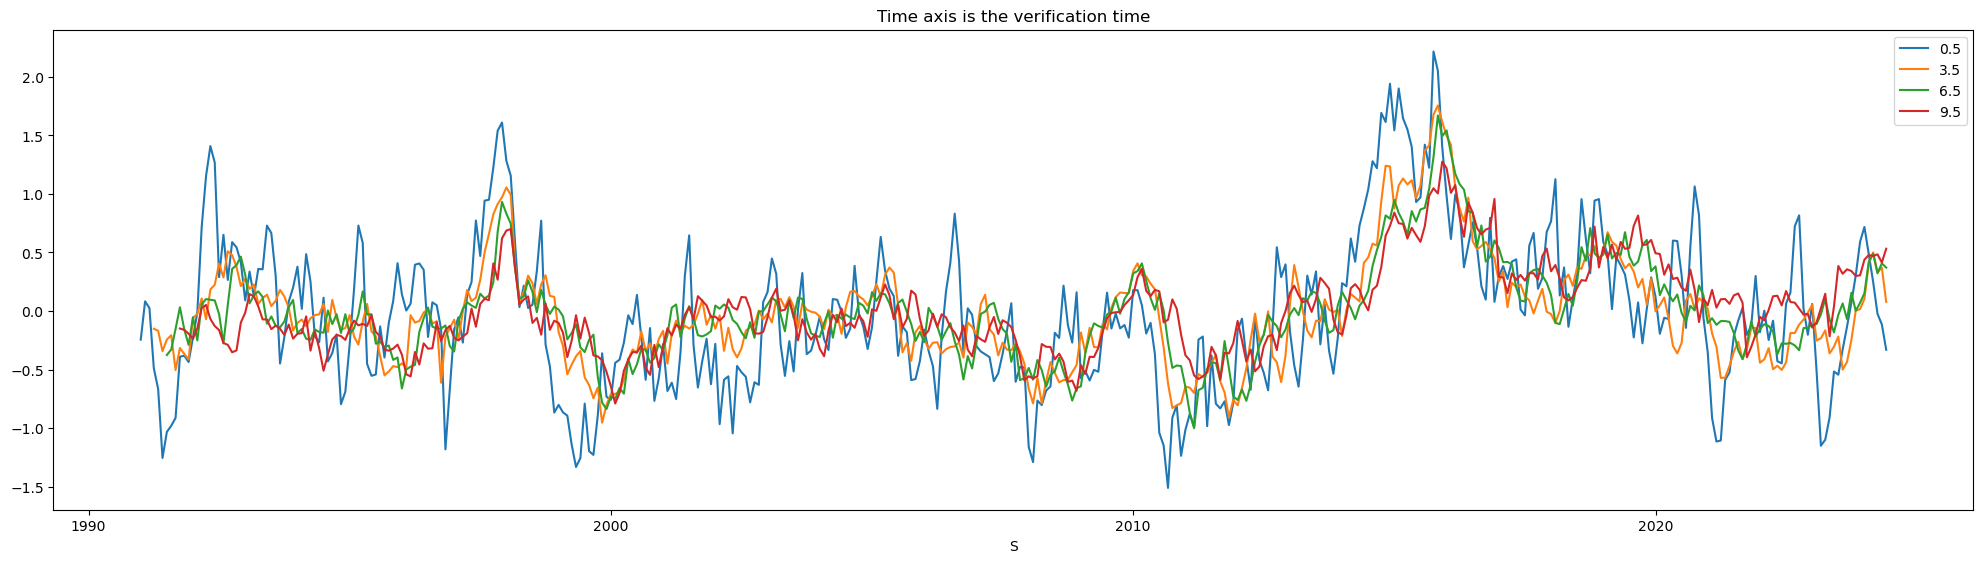

In [56]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
time = da_total_concat_mmm.S.data.copy()
for nl,l in enumerate(da_total_concat_mmm.L.data[::3]):
    if nl == 0:
        end = None
    else:
        end = -1*int(np.floor(l))
    time_plot = time[int(np.floor(l)):]
    da_crop = da_total_concat_mmm.sel(L=l).isel(S=slice(0,end))
    da_crop['S'] = time_plot
    da_crop.plot(label=l,ax=ax1)
plt.legend()
plt.title('Time axis is the verification time')

In [147]:
da_total_concat_mmm.sel(S='2010-01').data[5,7,10]

array([[ 0.17848183],
       [ 0.38693896],
       [ 0.44180068],
       [ 0.2949701 ],
       [ 0.15296762],
       [ 0.14148423],
       [ 0.14852083],
       [ 0.06711884],
       [-0.00405877],
       [ 0.09933627],
       [ 0.21736924],
       [ 0.09055245]], dtype=float32)

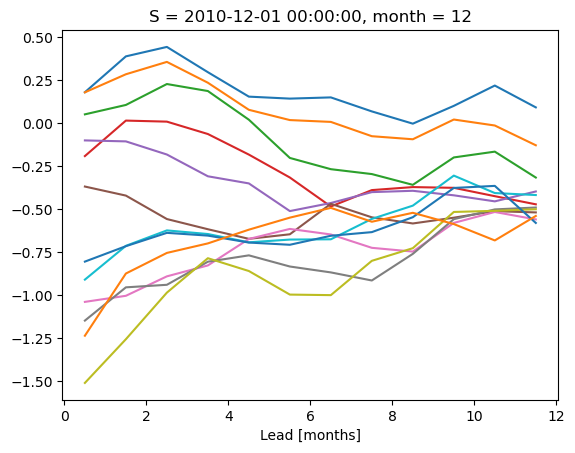

In [146]:
for month in range(1,13):
    da_total_concat_mmm.sel(S=f'2010-{month:02d}').plot()

In [59]:
da_total_concat_mean = da_total_concat.mean(dim=["X","Y"])

In [61]:
da_total_concat_mean_mmm = da_total_concat_mean.mean(dim='M').mean(dim='model')

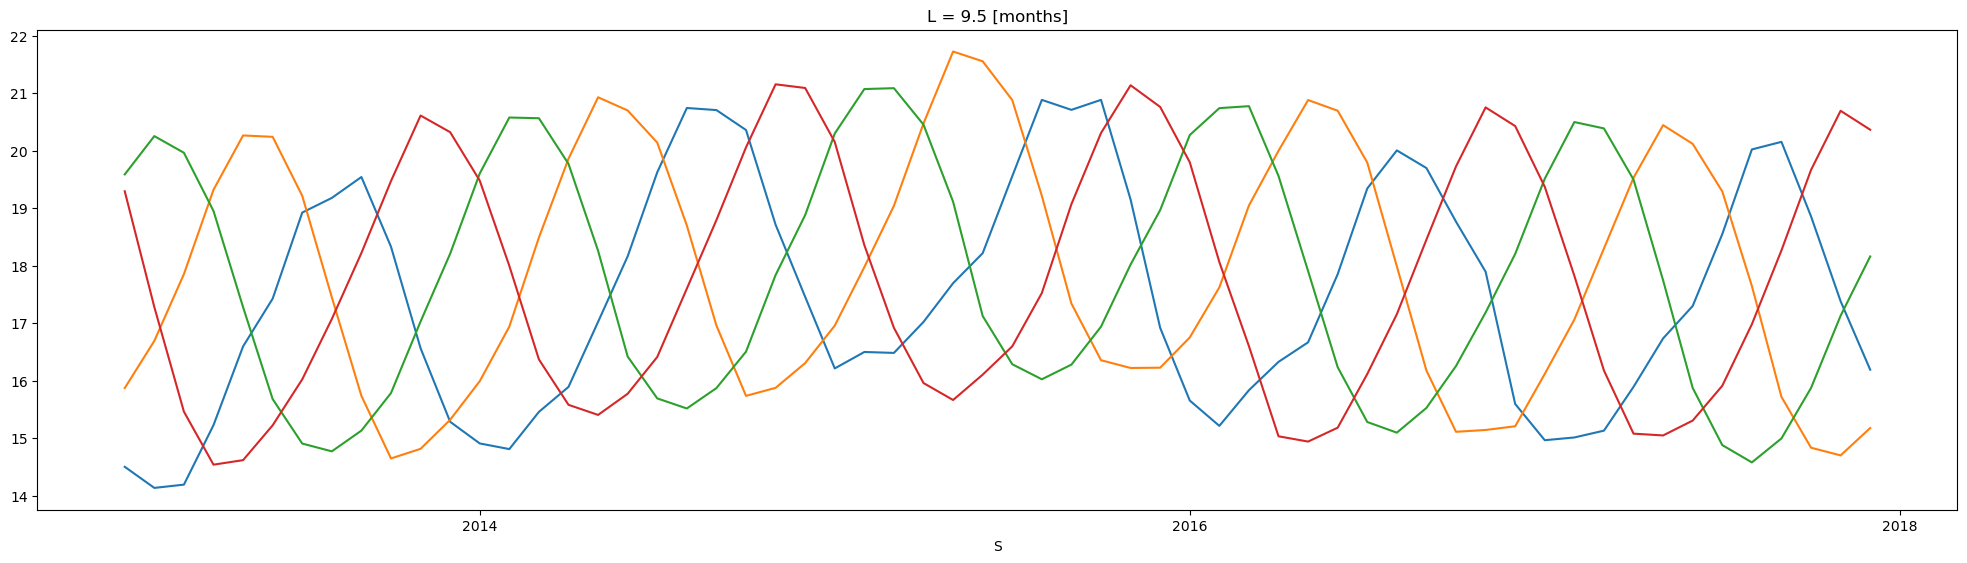

In [66]:
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for lead in da_total_concat_mean_mmm.L.data[::3]:
    da_total_concat_mean_mmm.sel(L=lead).sel(S=slice('2013-01','2017-12')).plot(ax=ax1)

In [6]:
da_total_mmm = da_total_concat.mean(dim='M').mean(dim='model')

In [7]:
da_total_mmm = da_total_mmm.rename({'S':'start_time','L':'lead_time'})

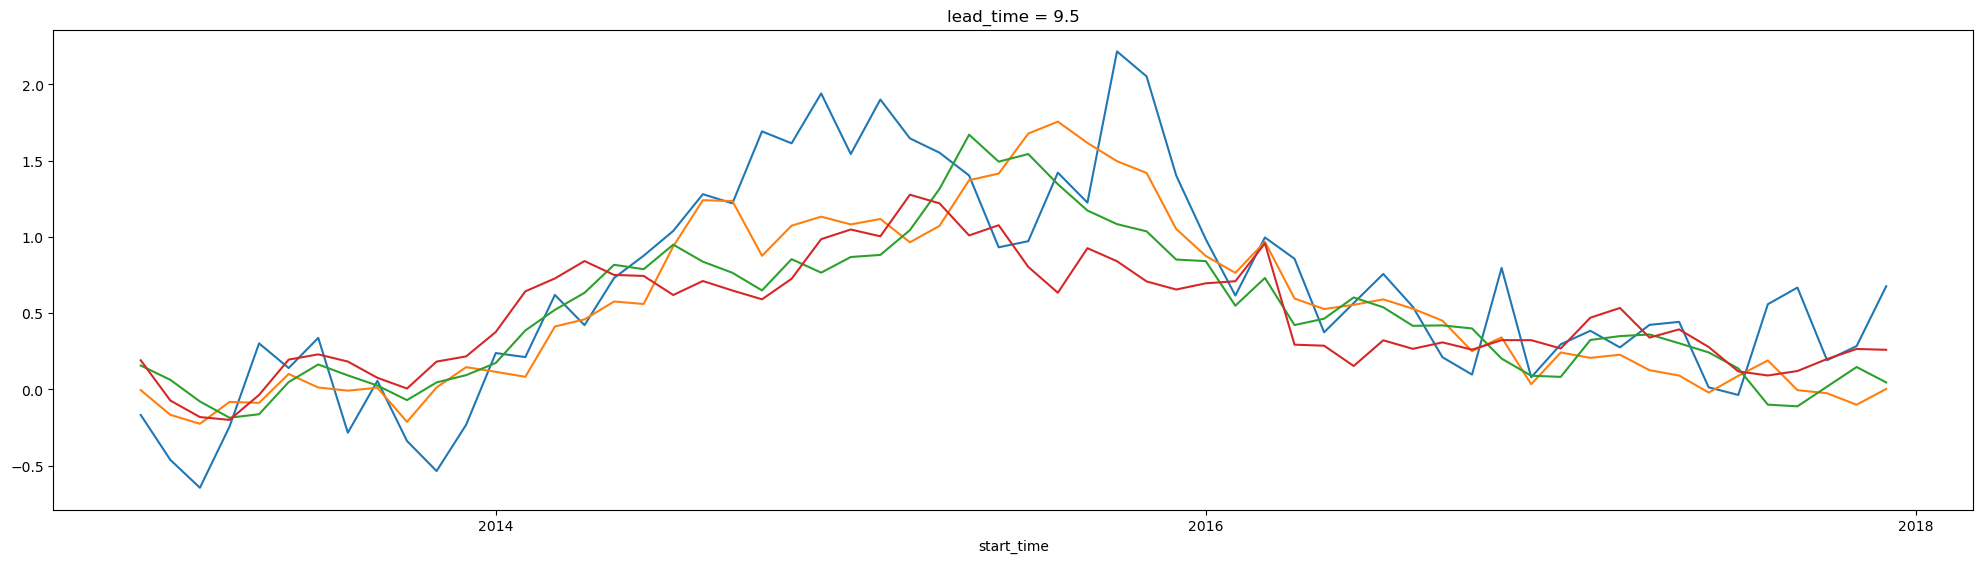

In [56]:
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
for lead in da_total_mmm.lead_time.data[::3]:
    da_total_mmm.sel(lead_time=lead).sel(start_time=slice('2013-01','2017-12')).plot(ax=ax1)

In [49]:
da_total.isel(start_time=slice(0,-1*nlead))

<xarray.DataArray (start_time: 0)> Size: 0B
array([], dtype=float32)
Coordinates:
    lead_time   float32 4B 0.5
  * start_time  (start_time) object 0B 
    month       (start_time) int64 0B

0.5
1.5
2.5
3.5
4.5
5.5
6.5
7.5
8.5
9.5
10.5
11.5


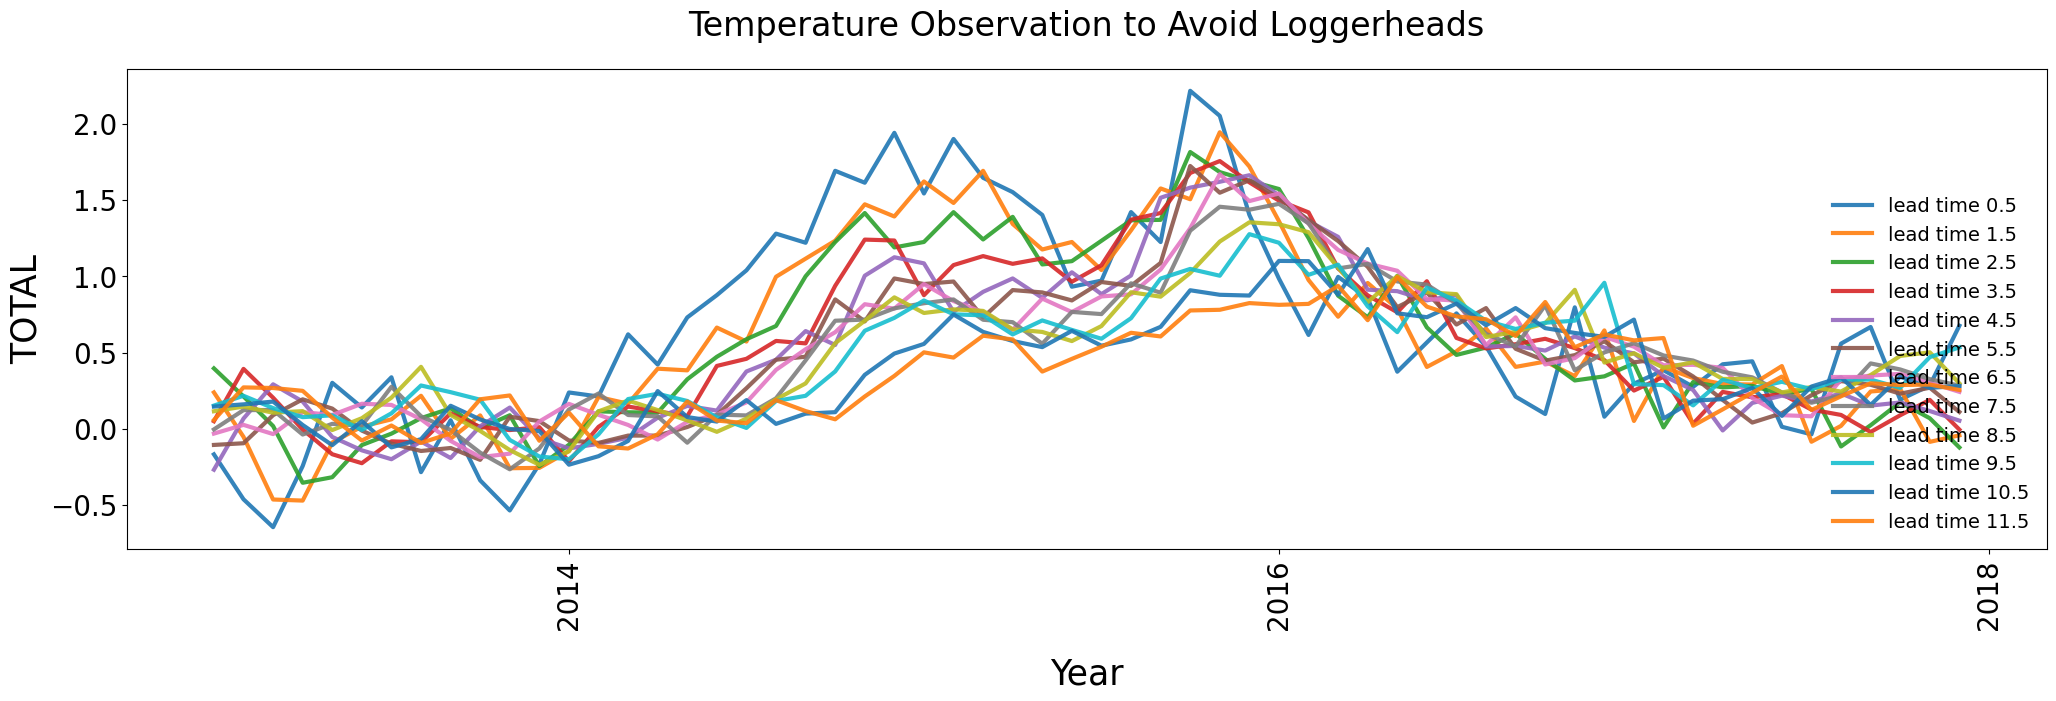

In [50]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])


for nlead,leadtime in enumerate(da_total_mmm.lead_time.data):
    print(leadtime)
    # time = da_total_mmm.sel(start_time=slice('2013-01','2017-12')).start_time.data
    da_total = da_total_mmm.sel(lead_time=leadtime)
    time = da_total.start_time.data.copy()
    
    if -1*nlead == 0:
        end = None
    else:
        end = -1*nlead
    da_crop = da_total.isel(start_time=slice(0,end)).copy()
    da_crop['start_time'] = time[nlead:]

    da_crop = da_crop.sel(start_time=slice('2013-01','2017-12'))

    (
    da_crop
    .plot(
        linestyle='solid',
        linewidth=3,
        ax=ax1,
        label=f'lead time {leadtime}',
        alpha=0.9,
    )
    )


    #### setting the plotting format
    ax1.set_ylabel('TOTAL',{'size':'25'},color='k')
    ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
    ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
    ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
    # ax1.set_xticks(da_crop.start_time[::5])
    # ax1.set_ylim([-0.1,1])
    ax1.set_title("Temperature Observation to Avoid Loggerheads",{'size':'24'},pad=24)
    ax1.legend(loc='lower right',fontsize=14,frameon=False)

0.5
3.5
6.5
8.5
11.5


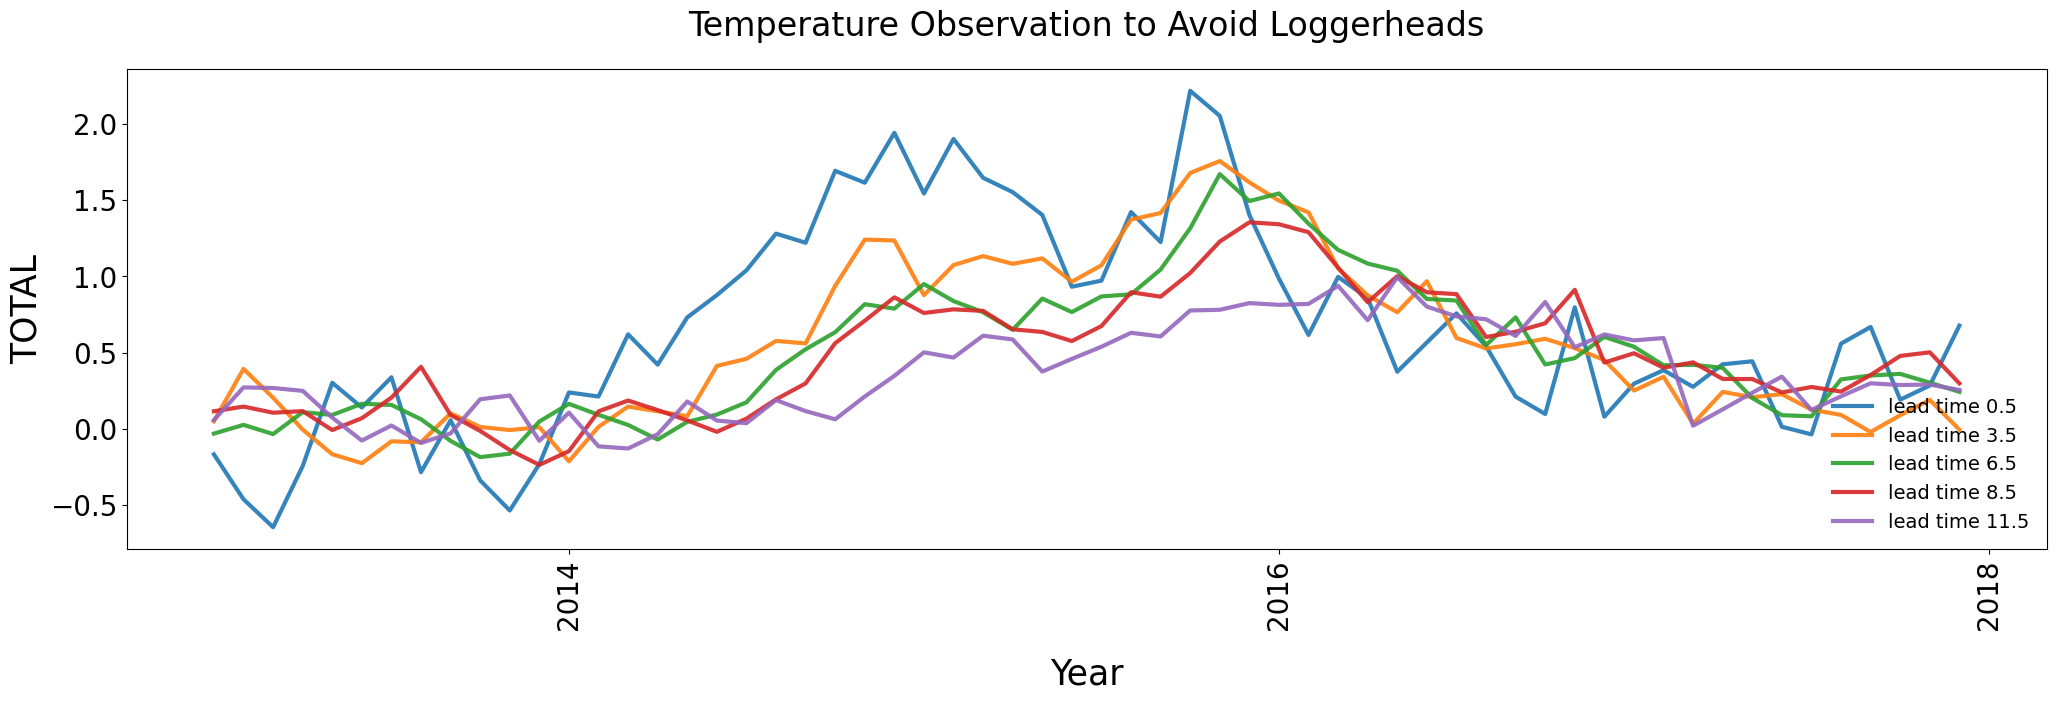

In [51]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
plot_lead = [0.5,3.5,6.5,8.5,11.5]

for nlead,leadtime in enumerate(da_total_mmm.lead_time.data):
    if leadtime in plot_lead:
        print(leadtime)
        # time = da_total_mmm.sel(start_time=slice('2013-01','2017-12')).start_time.data
        da_total = da_total_mmm.sel(lead_time=leadtime)
        time = da_total.start_time.data.copy()
        
        if -1*nlead == 0:
            end = None
        else:
            end = -1*nlead
        da_crop = da_total.isel(start_time=slice(0,end)).copy()
        da_crop['start_time'] = time[nlead:]

        da_crop = da_crop.sel(start_time=slice('2013-01','2017-12'))

        (
        da_crop
        .plot(
            linestyle='solid',
            linewidth=3,
            ax=ax1,
            label=f'lead time {leadtime}',
            alpha=0.9,
        )
        )


        #### setting the plotting format
        ax1.set_ylabel('TOTAL',{'size':'25'},color='k')
        ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
        ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
        ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
        # ax1.set_xticks(da_crop.start_time[::5])
        # ax1.set_ylim([-0.1,1])
        ax1.set_title("Temperature Observation to Avoid Loggerheads",{'size':'24'},pad=24)
        ax1.legend(loc='lower right',fontsize=14,frameon=False)

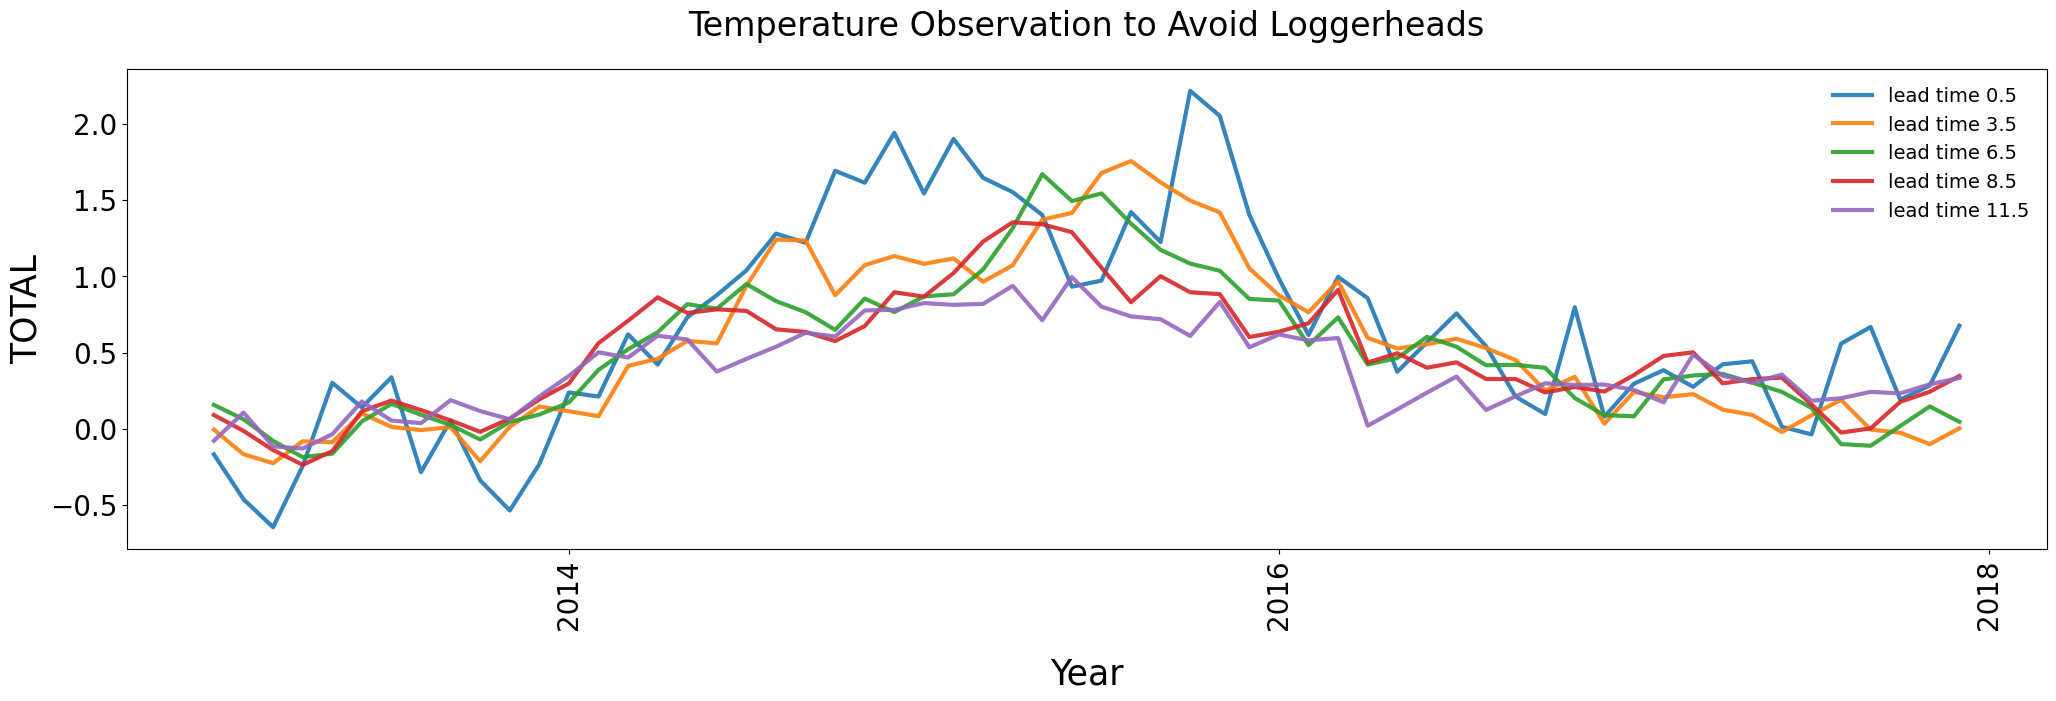

In [10]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
plot_lead = [0.5,3.5,6.5,8.5,11.5]


for nlead,leadtime in enumerate(da_total_mmm.lead_time.data):
    if leadtime in plot_lead:
        # time = da_total_mmm.sel(start_time=slice('2013-01','2017-12')).start_time.data
        da_total = da_total_mmm.sel(lead_time=leadtime)
        time = da_total.start_time.data.copy()
        
        da_crop = da_total.isel(start_time=slice(nlead,None)).copy()
        da_crop['start_time'] = time[nlead:]

        da_crop = da_crop.sel(start_time=slice('2013-01','2017-12'))

        (
        da_crop
        .plot(
            linestyle='solid',
            linewidth=3,
            ax=ax1,
            label=f'lead time {leadtime}',
            alpha=0.9,
        )
        )


        #### setting the plotting format
        ax1.set_ylabel('TOTAL',{'size':'25'},color='k')
        ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
        ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
        ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
        # ax1.set_xticks(da_crop.start_time[::5])
        # ax1.set_ylim([-0.1,1])
        ax1.set_title("Temperature Observation to Avoid Loggerheads",{'size':'24'},pad=24)
        ax1.legend(loc='upper right',fontsize=14,frameon=False)

In [16]:
da_total_mmm_6 = da_total_mmm.rolling(lead_time=6, center=False).mean()

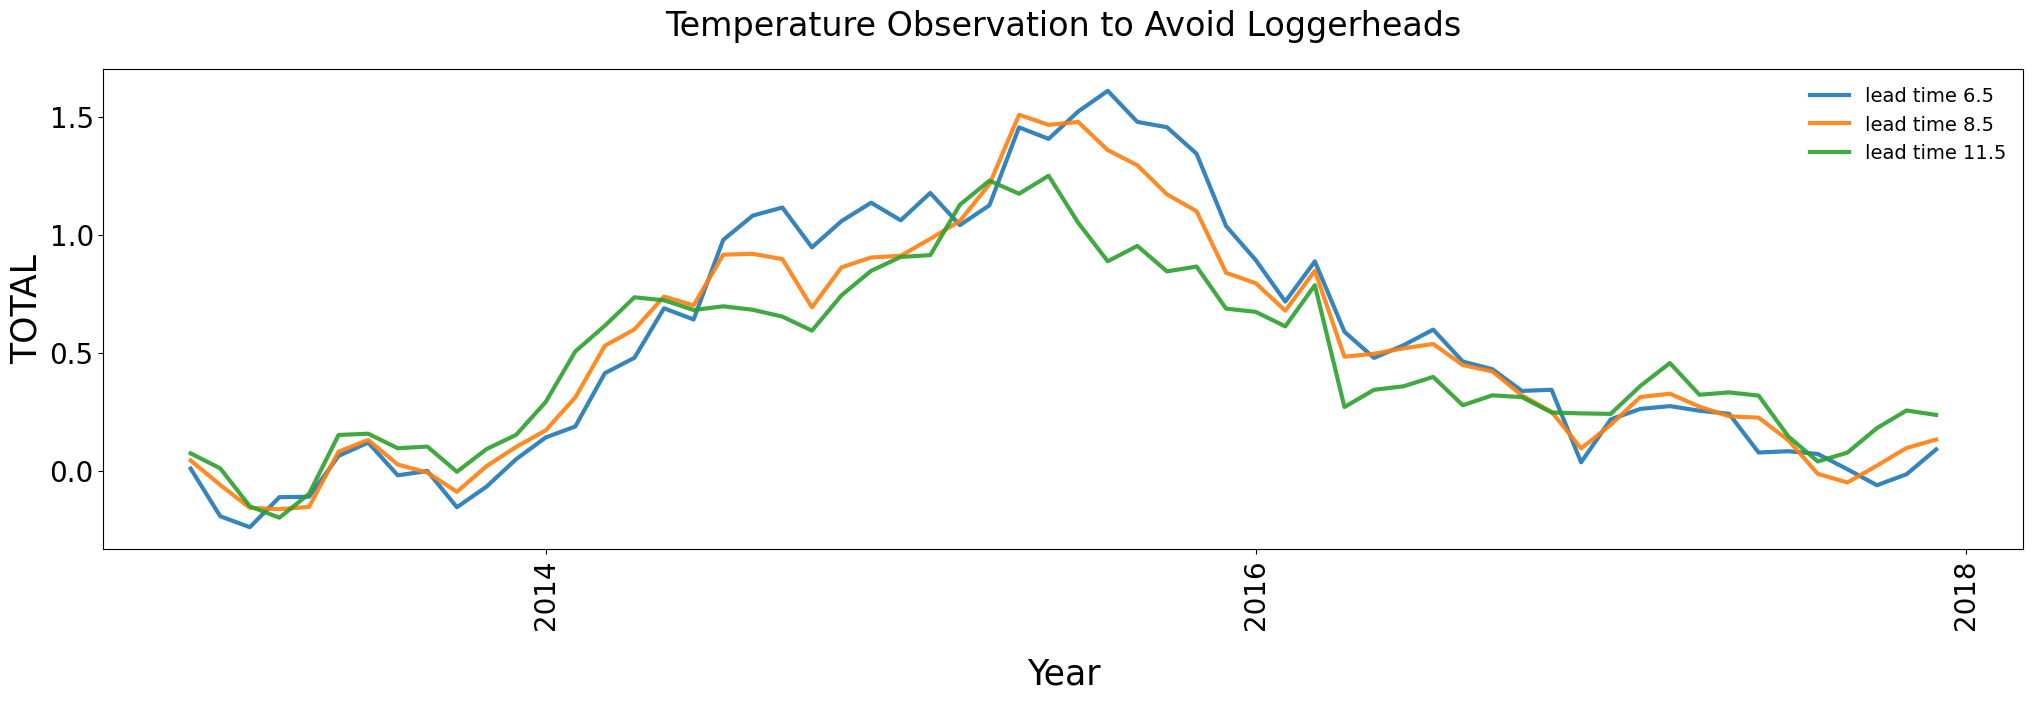

In [17]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
plot_lead = [6.5,8.5,11.5]


for nlead,leadtime in enumerate(da_total_mmm.lead_time.data):
    if leadtime in plot_lead:
        # time = da_total_mmm.sel(start_time=slice('2013-01','2017-12')).start_time.data
        da_total = da_total_mmm_6.sel(lead_time=leadtime)
        time = da_total.start_time.data.copy()
        
        da_crop = da_total.isel(start_time=slice(nlead,None)).copy()
        da_crop['start_time'] = time[nlead:]

        da_crop = da_crop.sel(start_time=slice('2013-01','2017-12'))

        (
        da_crop
        .plot(
            linestyle='solid',
            linewidth=3,
            ax=ax1,
            label=f'lead time {leadtime}',
            alpha=0.9,
        )
        )


        #### setting the plotting format
        ax1.set_ylabel('TOTAL',{'size':'25'},color='k')
        ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
        ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
        ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
        # ax1.set_xticks(da_crop.start_time[::5])
        # ax1.set_ylim([-0.1,1])
        ax1.set_title("Temperature Observation to Avoid Loggerheads",{'size':'24'},pad=24)
        ax1.legend(loc='upper right',fontsize=14,frameon=False)

In [19]:
da_total_6_mmm = da_total_concat.rolling(L=6, center=False).mean().mean(dim='M').mean(dim='model')

In [21]:
da_total_6_mmm = da_total_6_mmm.rename({'S':'start_time','L':'lead_time'})

1991-01-01 00:00:00
2024-06-01 00:00:00
1991-07-01 00:00:00
2024-06-01 00:00:00
1991-01-01 00:00:00
2024-06-01 00:00:00
1991-09-01 00:00:00
2024-06-01 00:00:00
1991-01-01 00:00:00
2024-06-01 00:00:00
1991-12-01 00:00:00
2024-06-01 00:00:00


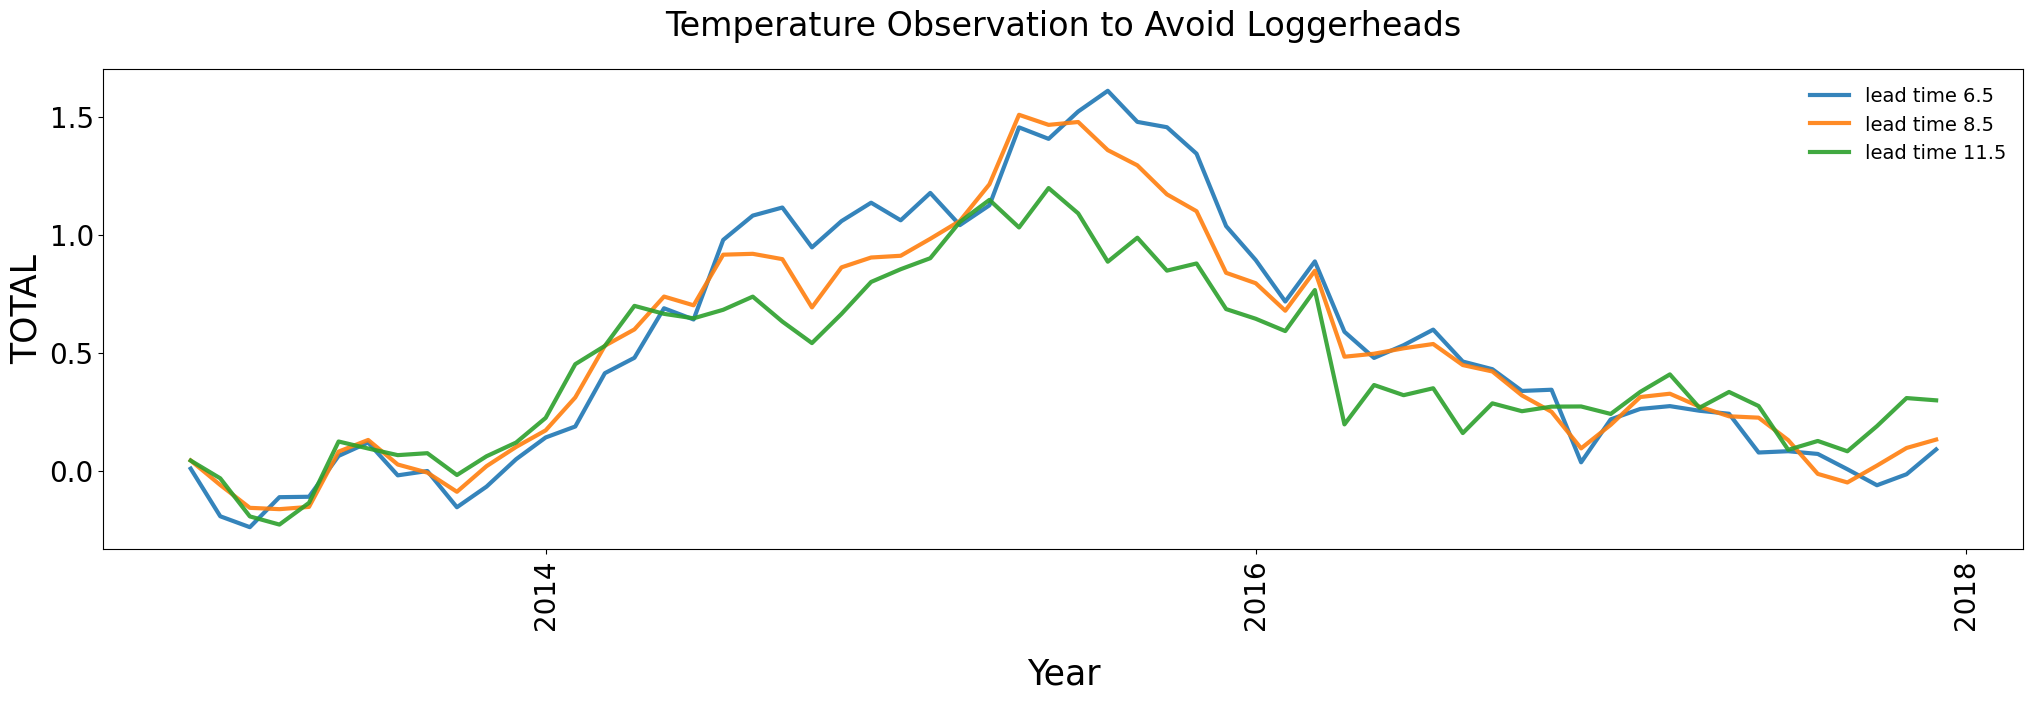

In [38]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
plot_lead = [6.5,8.5,11.5]

time = da_total_6_mmm.start_time.data.copy()
for nlead,leadtime in enumerate(da_total_mmm.lead_time.data):
    if leadtime in plot_lead:
        # time = da_total_mmm.sel(start_time=slice('2013-01','2017-12')).start_time.data
        da_cropped = da_total_6_mmm.sel(lead_time=leadtime).copy()
        print(da_cropped.isel(start_time=0).start_time.data) 
        print(da_cropped.isel(start_time=-1).start_time.data) 
        
        
        da_crop = da_cropped.isel(start_time=slice(nlead,None)).copy()
        # print(da_crop.isel(start_time=0).start_time.data) 
        # print(da_crop.isel(start_time=-1).start_time.data) 
        
        da_crop['start_time'] = time[nlead:]
        print(time[nlead:][0]) 
        print(time[nlead:][-1])        
        # print(da_crop.isel(start_time=0).start_time.data) 
        # print(da_crop.isel(start_time=-1).start_time.data) 

        da_crop = da_crop.sel(start_time=slice('2013-01','2017-12'))

        (
        da_crop
        .plot(
            linestyle='solid',
            linewidth=3,
            ax=ax1,
            label=f'lead time {leadtime}',
            alpha=0.9,
        )
        )


        #### setting the plotting format
        ax1.set_ylabel('TOTAL',{'size':'25'},color='k')
        ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
        ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
        ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
        # ax1.set_xticks(da_crop.start_time[::5])
        # ax1.set_ylim([-0.1,1])
        ax1.set_title("Temperature Observation to Avoid Loggerheads",{'size':'24'},pad=24)
        ax1.legend(loc='upper right',fontsize=14,frameon=False)

1991-01-01 00:00:00
2024-06-01 00:00:00
1991-01-01 00:00:00
2023-12-01 00:00:00
1991-07-01 00:00:00
2024-06-01 00:00:00
1991-01-01 00:00:00
2024-06-01 00:00:00
1991-01-01 00:00:00
2023-10-01 00:00:00
1991-09-01 00:00:00
2024-06-01 00:00:00
1991-01-01 00:00:00
2024-06-01 00:00:00
1991-01-01 00:00:00
2023-07-01 00:00:00
1991-12-01 00:00:00
2024-06-01 00:00:00


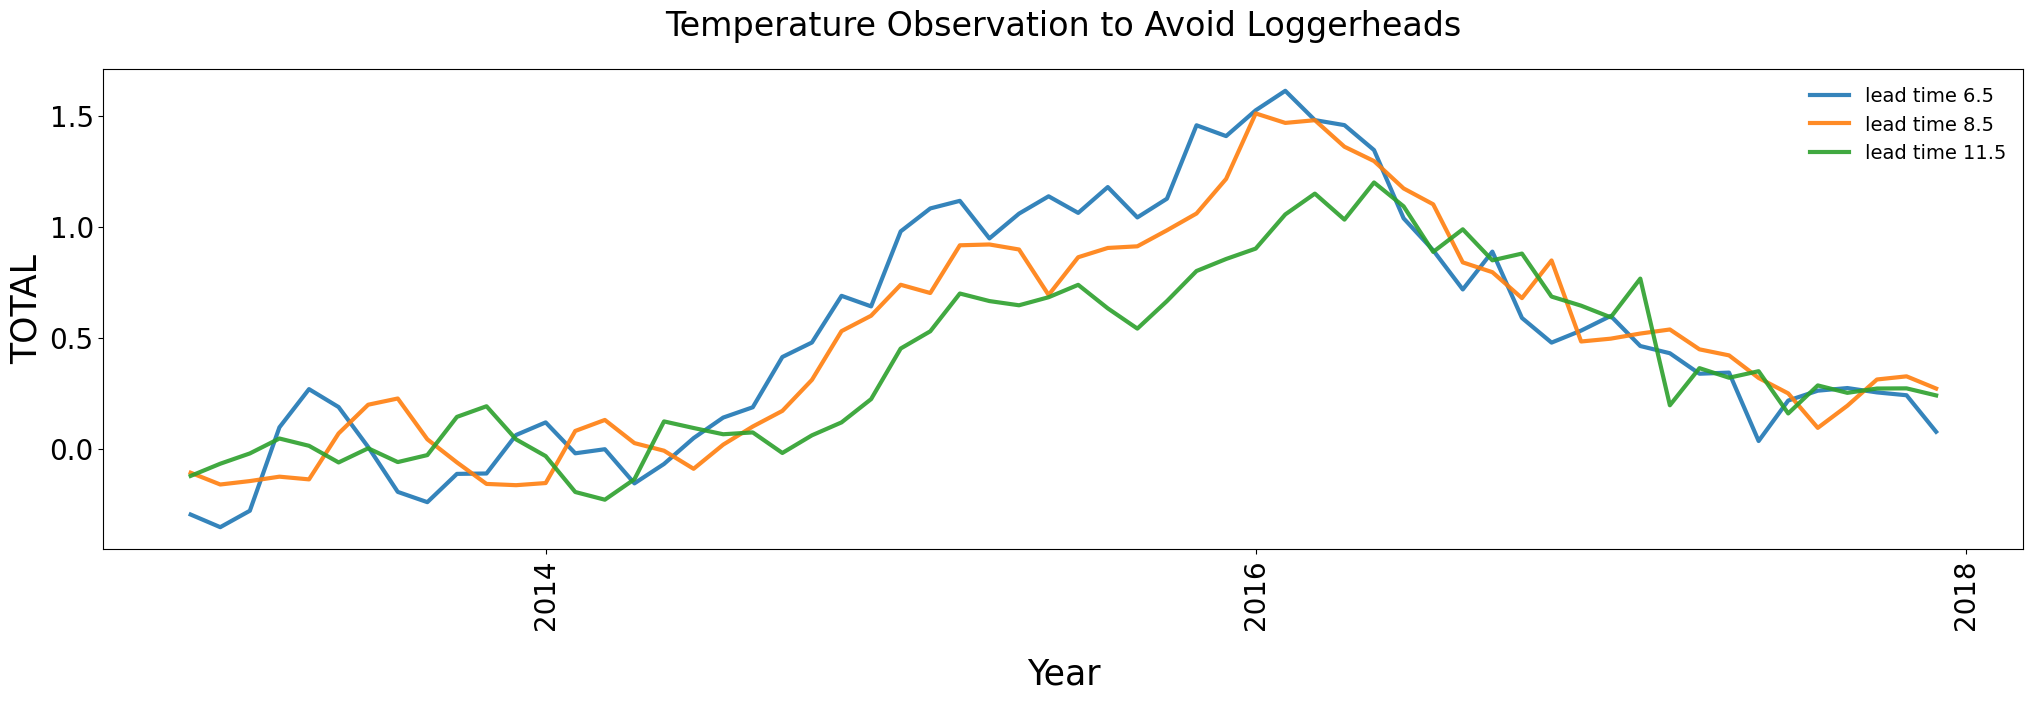

In [39]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
plot_lead = [6.5,8.5,11.5]

time = da_total_6_mmm.start_time.data.copy()
for nlead,leadtime in enumerate(da_total_mmm.lead_time.data):
    if leadtime in plot_lead:
        # time = da_total_mmm.sel(start_time=slice('2013-01','2017-12')).start_time.data
        da_cropped = da_total_6_mmm.sel(lead_time=leadtime).copy()
        print(da_cropped.isel(start_time=0).start_time.data) 
        print(da_cropped.isel(start_time=-1).start_time.data) 
        
        
        da_crop = da_cropped.isel(start_time=slice(None,-1*nlead)).copy()
        print(da_crop.isel(start_time=0).start_time.data) 
        print(da_crop.isel(start_time=-1).start_time.data) 
        
        da_crop['start_time'] = time[nlead:]
        print(time[nlead:][0]) 
        print(time[nlead:][-1])        
        # print(da_crop.isel(start_time=0).start_time.data) 
        # print(da_crop.isel(start_time=-1).start_time.data) 

        da_crop = da_crop.sel(start_time=slice('2013-01','2017-12'))

        (
        da_crop
        .plot(
            linestyle='solid',
            linewidth=3,
            ax=ax1,
            label=f'lead time {leadtime}',
            alpha=0.9,
        )
        )


        #### setting the plotting format
        ax1.set_ylabel('TOTAL',{'size':'25'},color='k')
        ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
        ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=90)
        ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
        # ax1.set_xticks(da_crop.start_time[::5])
        # ax1.set_ylim([-0.1,1])
        ax1.set_title("Temperature Observation to Avoid Loggerheads",{'size':'24'},pad=24)
        ax1.legend(loc='upper right',fontsize=14,frameon=False)

60
2012-07-01 00:00:00
2017-06-01 00:00:00
60
60
60


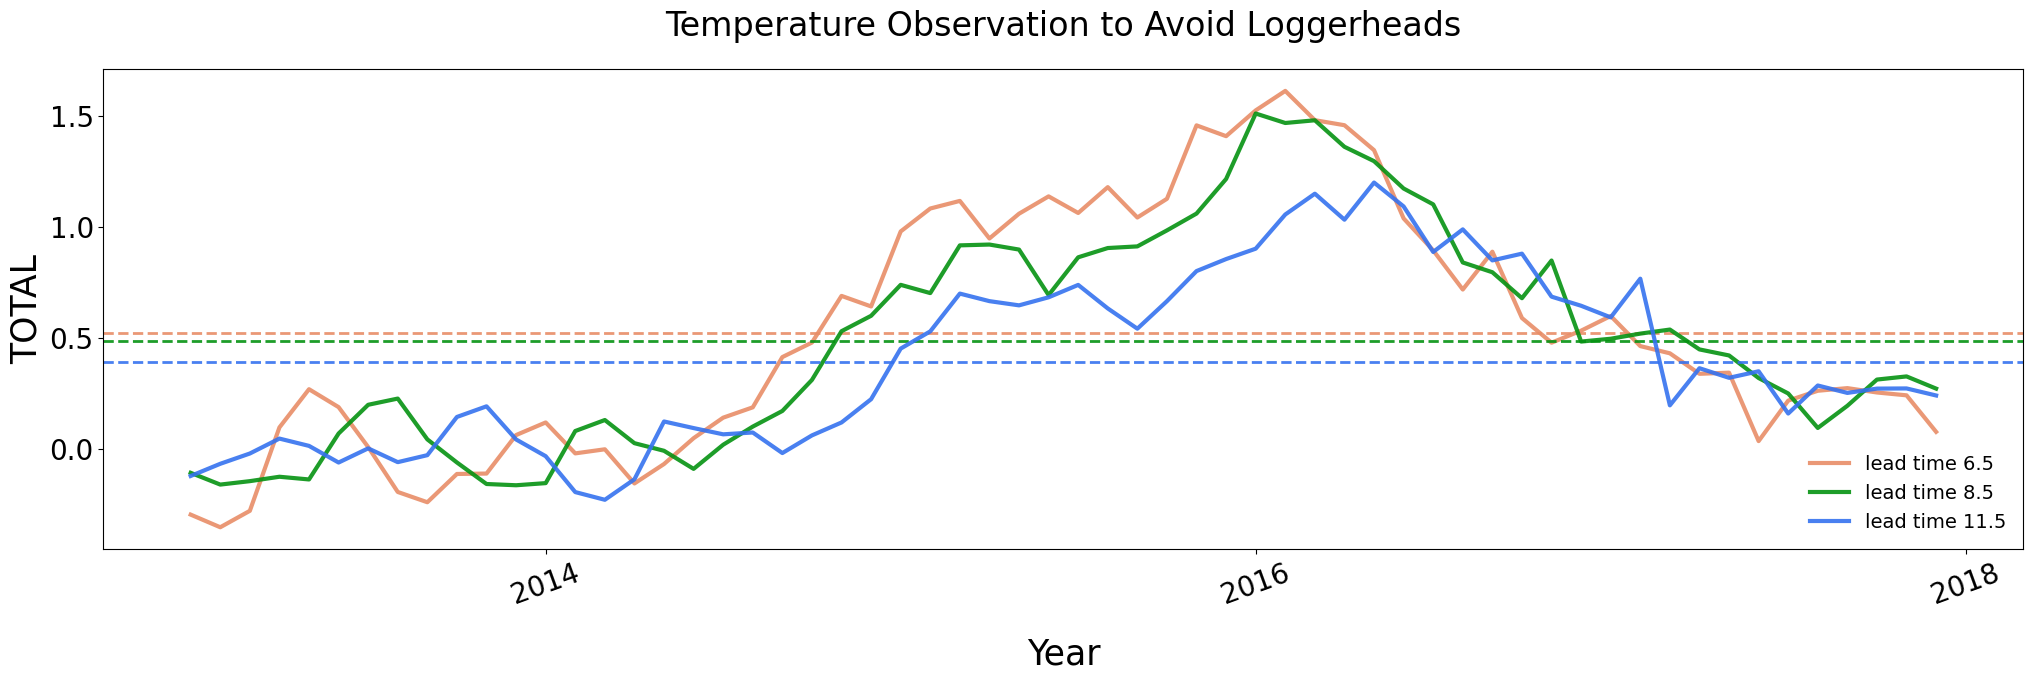

In [29]:
import matplotlib.pyplot as plt
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
lead_time = [6.5,8.5,11.5]
colors = ['#E88D67','#059212','#3572EF']
time = da_total_6_mmm.sel(start_time=slice('2013-01','2017-12')).start_time.data
print(len(time))

for nlead,leadtime in enumerate(lead_time):
    
    da_cropper = da_total_6_mmm.sel(lead_time=leadtime).copy()
     
    if leadtime == 6.5:
        da_cropper = da_cropper.sel(start_time=slice('2012-06','2017-0'))
        print(da_cropper.isel(start_time=0).start_time.data) 
        print(da_cropper.isel(start_time=-1).start_time.data) 
    elif leadtime == 8.5:
        da_cropper = da_cropper.sel(start_time=slice('2012-05','2017-04'))
    elif leadtime == 11.5:
        da_cropper = da_cropper.sel(start_time=slice('2012-02','2017-01'))
    print(len(da_cropper))
    da_cropper['start_time'] = time

    (
    da_cropper
    .plot(
        color=colors[nlead],
        linestyle='solid',
        linewidth=3,
        ax=ax1,
        label=f'lead time {leadtime}',
        alpha=0.9,
    )
    )

    mean = (
    da_cropper
    .mean('start_time')
    )
    ax1.axhline(
        y=mean,
        linestyle='dashed',
        linewidth=2,
        alpha=0.9,
        color=colors[nlead],
    )


    #### setting the plotting format
    ax1.set_ylabel('TOTAL',{'size':'25'},color='k')
    ax1.tick_params(axis='y',labelsize=20,labelcolor='k')
    ax1.tick_params(axis='x',labelsize=20,labelcolor='k',rotation=20)
    ax1.set_xlabel('Year',{'size':'25'},labelpad=20)
    # ax1.set_ylim([-0.1,1])
    ax1.set_title("Temperature Observation to Avoid Loggerheads",{'size':'24'},pad=24)
    ax1.legend(loc='lower right',fontsize=14,frameon=False)